In [23]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)

slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=10)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.01)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=10)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,10),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:

    trace = pm.sample(1000, tune=500, cores=2, random_seed=0, target_accept=0.99)

    pm.backends.save_trace(trace,'real_rh_test_1' + '.trace',model_sunode)

print('real_rh')
print('done')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y0, z, c2, tau, l, sigma]
Sampling 2 chains, 22 divergences: 100%|██████████| 3000/3000 [1:35:44<00:00,  1.91s/draws]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


real_rh
done


In [24]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
z[0],1.172,0.704,0.066,2.584,0.111,0.079,40.0,40.0,41.0,138.0,1.06
z[1],0.083,0.842,-1.482,1.835,0.100,0.071,71.0,71.0,79.0,209.0,1.03
z[2],0.164,0.843,-1.335,1.875,0.151,0.108,31.0,31.0,29.0,94.0,1.12
z[3],-1.119,0.569,-2.138,-0.224,0.097,0.069,35.0,35.0,37.0,159.0,1.02
z[4],-0.984,0.549,-2.042,-0.116,0.057,0.040,94.0,94.0,96.0,286.0,1.02
z[5],1.036,0.534,0.198,2.016,0.046,0.033,134.0,134.0,126.0,280.0,1.01
z[6],0.308,0.936,-1.440,2.222,0.354,0.261,7.0,7.0,10.0,11.0,1.15
z[7],0.255,0.602,-0.874,1.490,0.067,0.079,81.0,30.0,74.0,129.0,1.06
z[8],0.081,0.875,-1.379,1.987,0.278,0.203,10.0,10.0,10.0,37.0,1.16
z[9],-0.366,0.760,-1.825,1.162,0.085,0.060,80.0,80.0,86.0,78.0,1.03


/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/bara947/.local/miniconda/envs/mars-sunode/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/dis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x143525b50>,
      dtype=object)

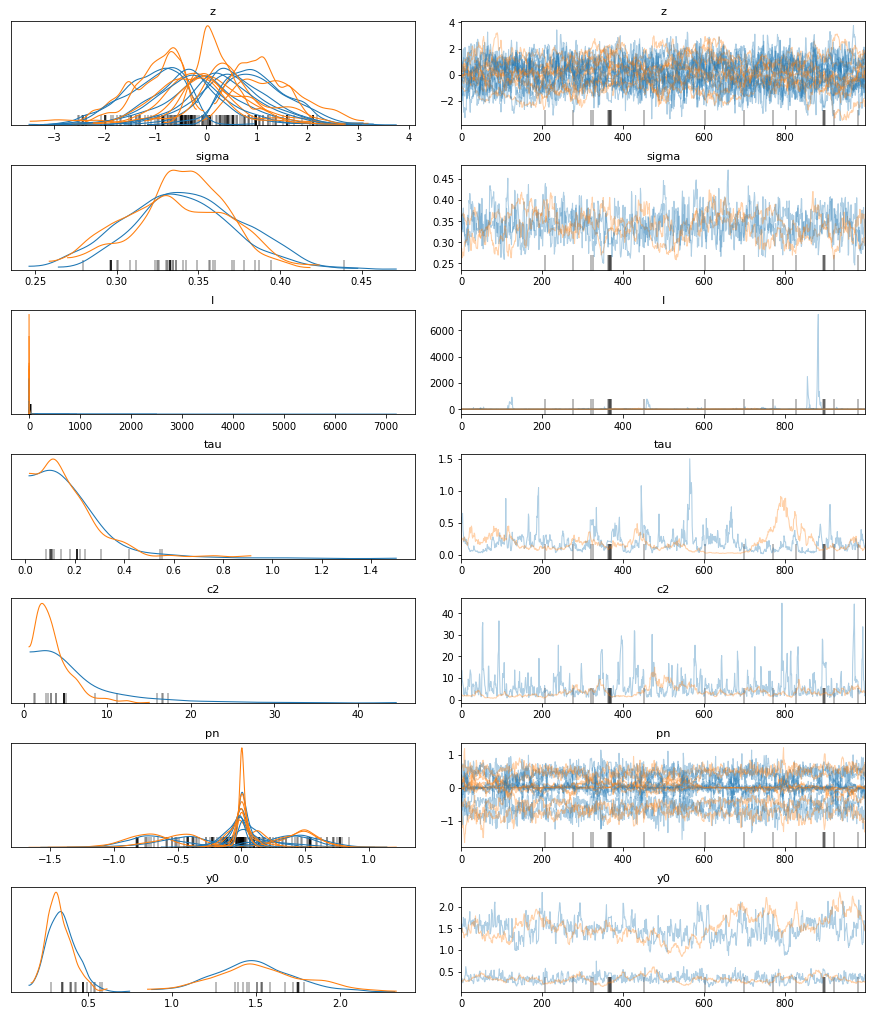

In [25]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1424fa210>],
      dtype=object)

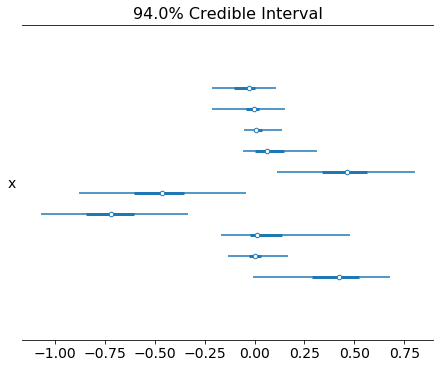

In [26]:
pm.forestplot(trace['pn'].T)